## ATMS 523 Assignment 5
Several Machine learning methods on predicting rain rate with radar data.

### Load libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

### Read and process initial data

In [4]:
# Load data
Data = pd.read_csv("homework/radar_parameters.csv", index_col=0)
Data.head()

,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291


In [6]:
X_radar = Data.iloc[:, [0, 1, 2, 3, 4, 5]]
y_radar = Data.iloc[:, 6]

In [7]:
# Split train test
Xtrain, Xtest, ytrain, ytest = train_test_split(X_radar, y_radar, random_state=2)

### Baseline model

In [8]:
def baseline(X):
    Z = 10 ** (X["Zh (dBZ)"] / 10)
    return (Z / 200) ** (1 / 1.6)

### Linear Regression

In [9]:
model_LR = LinearRegression(fit_intercept=True)
model_LR.fit(Xtrain, ytrain)

LinearRegression()

Perform complete evaluation of baseline and linear model since they are not cross-validated

In [10]:
y_base = baseline(X_radar)
y_LR = model_LR.predict(X_radar)

LR_r2_full = r2_score(y_radar, y_LR)
LR_r2_train = r2_score(ytrain, model_LR.predict(Xtrain))
LR_r2_test = r2_score(ytest, model_LR.predict(Xtest))

BS_r2_full = r2_score(y_radar, y_base)
BS_r2_train = r2_score(ytrain, baseline(Xtrain))
BS_r2_test = r2_score(ytest, baseline(Xtest))

LR_rms_full = mean_squared_error(y_radar, y_LR, squared=False)
LR_rms_train = mean_squared_error(ytrain, model_LR.predict(Xtrain), squared=False)
LR_rms_test = mean_squared_error(ytest, model_LR.predict(Xtest), squared=False)

BS_rms_full = mean_squared_error(y_radar, y_base, squared=False)
BS_rms_train = mean_squared_error(ytrain, baseline(Xtrain), squared=False)
BS_rms_test = mean_squared_error(ytest, baseline(Xtest), squared=False)

print(LR_r2_full, LR_r2_train, LR_r2_test)
print(BS_r2_full, BS_r2_train, BS_r2_test)
print(LR_rms_full, LR_rms_train, LR_rms_test)
print(BS_rms_full, BS_rms_train, BS_rms_test)

0.9880453634754818 0.9892072326615635 0.9836989252404956
0.3023229070437503 0.3023001413415827 0.30127300824002956
0.9369314661630308 0.9125655644560922 1.006482020184342
7.157590840042378 7.337227526472471 6.5894878512067745


Linear regression have better performance than baseline model. \
Training set performs better in linear regression.

### Grid search for polynomial regression.

In [22]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))


param_grid = {
    "polynomialfeatures__degree": np.arange(7),
    "linearregression__fit_intercept": [True, False],
    "linearregression__normalize": [True, False],
}

grid = GridSearchCV(
    PolynomialRegression(), param_grid, cv=7, verbose=10, n_jobs=-2
)

In [ ]:
grid.fit(X_radar, y_radar)

In [24]:
print(grid.best_params_)

{'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'polynomialfeatures__degree': 2}


Get model performance

In [25]:
# get R^2 score and RMSE
model_GS = grid.best_estimator_
y_GS = model_GS.predict(X_radar)
GS_r2_full = r2_score(y_radar, y_GS)
GS_rms_full = mean_squared_error(y_radar, y_GS, squared=False)
print(GS_r2_full, GS_rms_full)

0.9996006830823455 0.17123734740129123


Performance of best polynomial regression is better than all previous models.

### Random Forest Regression

First round random forest grid search

In [14]:
# this long run choose some best parameters from a large pool of grid.

rfr_grid = {
    "bootstrap": [True, False],
    "max_depth": [None, 100, 60, 20],
    "max_features": [1.0, "sqrt"],  # 'auto' is 1.0 in new version
    "min_samples_leaf": [4, 2, 1],
    "min_samples_split": [10, 5, 2],
    "n_estimators": [1200, 800, 400],
}
# Preliminary best parameters saved here:
# {'bootstrap': True, 'max_depth': 100, 'max_features': 1.0,
#  'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}

grid_rfr = GridSearchCV(
    RandomForestRegressor(), rfr_grid, cv=7, verbose=10, n_jobs=-2
)

In [15]:
# 1.5 hours on my device
grid_rfr.fit(X_radar, y_radar)

Fitting 7 folds for each of 432 candidates, totalling 3024 fits


GridSearchCV(cv=7, estimator=RandomForestRegressor(), n_jobs=-2,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 100, 60, 20],
                         'max_features': [1.0, 'sqrt'],
                         'min_samples_leaf': [4, 2, 1],
                         'min_samples_split': [10, 5, 2],
                         'n_estimators': [1200, 800, 400]},
             verbose=10)

In [16]:
print(grid_rfr.best_params_)

{'bootstrap': True, 'max_depth': 100, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


Following rounds of random forest

In [16]:
# this grid is updated several times for tuning,
# typically by slight variation of each parameter.

rfr_grid = {
    "bootstrap": [True],
    "max_depth": [90],
    "max_features": [1.0],
    "min_samples_leaf": [2],
    "min_samples_split": [5, 4, 3, 2],
    "n_estimators": [500],
}
# Best params ever encountered is recorded here:
# {'bootstrap': True, 'max_depth': 90, 'max_features': 1.0,
#  'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 500}

grid_rfr = GridSearchCV(
    RandomForestRegressor(), rfr_grid, cv=7, verbose=10, n_jobs=-2
)

In [17]:
grid_rfr.fit(X_radar, y_radar)

Fitting 7 folds for each of 4 candidates, totalling 28 fits


GridSearchCV(cv=7, estimator=RandomForestRegressor(), n_jobs=-2,
             param_grid={'bootstrap': [True], 'max_depth': [90],
                         'max_features': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [5, 4, 3, 2],
                         'n_estimators': [500]},
             scoring='r2', verbose=10)

In [20]:
print(grid_rfr.best_params_)

{'bootstrap': True, 'max_depth': 90, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


Get model performance

In [21]:
# get the score of the final random forest model
model_RFR = grid_rfr.best_estimator_
y_RFR = model_RFR.predict(X_radar)
RFR_r2_full = r2_score(y_radar, y_RFR)
RFR_rms_full = mean_squared_error(y_radar, y_RFR, squared=False)
print(RFR_r2_full, RFR_rms_full)

0.996105645630274 0.5347580987704079


### Summary of all model performance:
Best Polynomial Regression > Best Random Forest Regression > Linear Regression > Baseline

In [45]:
print("Statistics  R^2 and            RMSE for full dataset")

print("Baseline   ", BS_r2_full, BS_rms_full)
print("Linear reg ", LR_r2_full, LR_rms_full)
print("GS polyreg ", GS_r2_full, GS_rms_full)
print("GS rforest ", RFR_r2_full, RFR_rms_full)

Statistics  R^2 and            RMSE for full dataset
Baseline    0.3023229070437503 7.157590840042378
Linear reg  0.9880453634754818 0.9369314661630308
GS polyreg  0.9996006830823455 0.1712373474012892
GS rforest  0.9960806187945693 0.5364736424620309


### Visualize the model performance

(-10.0, 210.0)

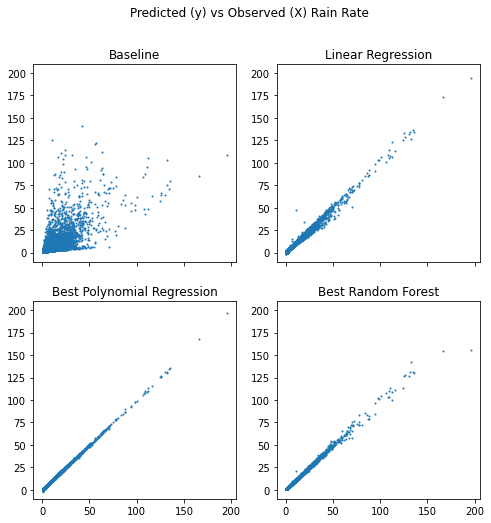

In [87]:
# plot scatter plots of 4 models, prediction against observation.
# ideal model should show straight line with slope 1.

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
fig.suptitle("Predicted (y) vs Observed (X) Rain Rate")

axes[0][0].set_title("Baseline")
axes[0][1].set_title("Linear Regression")
axes[1][0].set_title("Best Polynomial Regression")
axes[1][1].set_title("Best Random Forest")

axes[0][0].scatter(y_radar, y_base, s=1)
axes[0][1].scatter(y_radar, y_LR, s=1)
axes[1][0].scatter(y_radar, y_GS, s=1)
axes[1][1].scatter(y_radar, y_RFR, s=1)

axes[0][0].set_ylim(-10, 210)
axes[0][1].set_ylim(-10, 210)
axes[1][0].set_ylim(-10, 210)
axes[1][1].set_ylim(-10, 210)